In [33]:
import hoomd

import hoomd.pair_plugin.pair as ppair

from monk import prep, pair

import ex_render

import numpy as np

In [46]:
N = 512
D = 2
phi_initial = 0.6
phi_final = 0.6
L = prep.len_from_phi(N, phi_initial, dim=D)
L_final = prep.len_from_phi(N, phi_final, dim=D)

In [47]:
device = hoomd.device.auto_select()
sim = hoomd.Simulation(device, seed=1234)

rng = prep.init_rng(123)
snap = prep.approx_euclidean_snapshot(N, L, rng, dim=D, particle_types=["A", "B"], ratios=[50, 50], diams=[1.0, 1.4])
snap.particles.moment_inertia = N*[[0, 0, 1]]
snap.configuration.box = [L, 2*L, 0.0, 0.0, 0.0, 0.0]

sim.create_state_from_snapshot(snap)

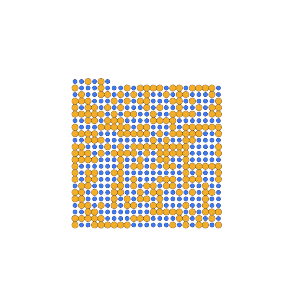

In [48]:
ex_render.render_disk_frame(frame=sim.state.get_snapshot())

In [53]:
# thermalize the system

integrator = hoomd.md.Integrator(dt=0.01, integrate_rotational_dof=False)
nvt = hoomd.md.methods.NVT(hoomd.filter.All(), 0.01, 1.0)
tree = hoomd.md.nlist.Tree(0.3)
flj = ppair.HarmHPF(tree, default_r_cut=1.0, mode="none")
flj.params[('A', 'A')] = dict(k=10.0, rcut=1.0)
flj.r_cut[('A', 'A')] = 1.0
flj.params[('A', 'B')] = dict(k=10.0, rcut=1.2)
flj.r_cut[('A', 'B')] = 1.2
flj.params[('B', 'B')] = dict(k=10.0, rcut=1.4)
flj.r_cut[('B', 'B')] = 1.4

# flj = hoomd.md.pair.LJ(tree, default_r_cut=2.5)
# flj.params[('A', 'A')] = dict(epsilon=1.0, sigma=1.0)


integrator.forces = [flj]
integrator.methods = [nvt]

sim.operations.integrator = integrator

In [54]:
sim.run(0)

nvt.thermalize_thermostat_dof()

sim.run(10_000)

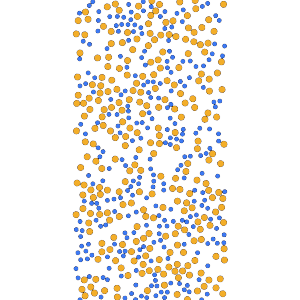

In [55]:
ex_render.render_disk_frame(frame=sim.state.get_snapshot())

In [56]:
hoomd.write.GSD.write(sim.state, "new_test_2d.gsd")

In [72]:
device = hoomd.device.auto_select()
sim = hoomd.Simulation(device, seed=1234)

sim.create_state_from_gsd("new_test_2d.gsd")

In [73]:
# thermalize the system

k = 10.0

# integrator = hoomd.md.minimize.FIRE(
#     dt=0.01,
#     force_tol=1e-2,
#     angmom_tol=1e-2,
#     energy_tol=1e-2,
#     integrate_rotational_dof=True)
integrator = hoomd.md.Integrator(dt=0.01, integrate_rotational_dof=True)
nvt = hoomd.md.methods.NPT(hoomd.filter.All(), 0.01, 1.0, 0.2, 4.0, couple="none", box_dof=(False, True, False, False, False, False), gamma=0.1)
# nvt = hoomd.md.methods.Langevin(hoomd.filter.All(), 0.0, 1.0)
tree = hoomd.md.nlist.Tree(0.2)
flj = ppair.HarmHPF(tree, default_r_cut=1.0, mode="none", mus=10.0, ks=10.0)
flj.params[('A', 'A')] = dict(k=10.0, rcut=1.0)
flj.r_cut[('A', 'A')] = 1.0
flj.params[('A', 'B')] = dict(k=10.0, rcut=1.2)
flj.r_cut[('A', 'B')] = 1.2
flj.params[('B', 'B')] = dict(k=10.0, rcut=1.4)
flj.r_cut[('B', 'B')] = 1.4

integrator.forces = [flj]
integrator.methods = [nvt]

sim.operations.integrator = integrator

writer = hoomd.write.GSD(trigger=hoomd.trigger.Periodic(100), filename="new_test_w_rolling_friction.gsd", mode="wb", filter=hoomd.filter.All(), dynamic=["property", "momentum"])
sim.operations.writers.clear()
sim.operations.writers.append(writer)


class MyConstantShear(hoomd.custom.Action):
    """Apply a constant shear rate to the simulation box.
    
    Arguments
    ---------
    - gamma: float - the shear rate (in units of box ratio per time step)
    - timestep: int - the initial reference timestep
    - pair: str - the dimension pair to apply the shear to"""
    def __init__(self, gamma: float, timestep: int, pair: str = "xz"):
        super().__init__()
        self._gamma = gamma
        self._last_timestep = timestep
        match pair:
            case "xy":
                self._pair_mode = 0
            case "yz":
                self._pair_mode = 1
            case "xz":
                self._pair_mode = 2

    def act(self, timestep):
        time_diff = timestep - self._last_timestep
        self._last_timestep = timestep
        box = self._state.box
        match self._pair_mode:
            case 0: # xy
                xy = box.xy + self._gamma * time_diff
                if xy > 0.5:
                    xy -= 1.0
                elif xy < -0.5:
                    xy += 1.0
                box.xy = xy
            case 1: # yz
                yz = box.yz + self._gamma * time_diff
                if yz > 0.5:
                    yz -= 1.0
                elif yz < -0.5:
                    yz += 1.0
                box.yz = yz
            case 2: # xz
                xz = box.xz + self._gamma * time_diff
                if xz > 0.5:
                    xz -= 1.0
                elif xz < -0.5:
                    xz += 1.0
                box.xz = xz
        self._state.set_box(box)

*Warning*: Requested integration of orientations, but no forces provide torques.


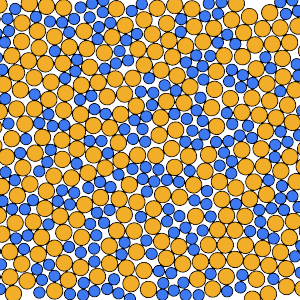

In [74]:
sim.run(10_000)
ex_render.render_disk_frame(frame=sim.state.get_snapshot())

In [75]:
custom_action = MyConstantShear(1e-4, sim.timestep, pair="xy")
box_resize = hoomd.update.CustomUpdater(hoomd.trigger.Periodic(10), custom_action)

sim.operations.updaters.append(box_resize)

In [76]:
sim.run(30_000)

*Warning*: Requested integration of orientations, but no forces provide torques.
